# **Practice Activity 7.2**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score

## **Part 1**

Make a pipeline that uses all the variables in the Ames dataset, and then fits Ridge Regression with lambda = 1
.

Cross-validate this pipeline and compare the results to the ordinary linear regression.

Then fit the model on the whole dataset and get the coefficients. Make a plot of these coefficients compared to the ones from ordinary linear regression.

In [ ]:
ames = pd.read_csv("https://www.dropbox.com/scl/fi/g0n5le5p6fr136ggetfsf/AmesHousing.csv?rlkey=jlr9xtz1o6u5rghfo29a5c02f&dl=1")

# Get rid of columns with mostly NaN values
good_cols = ames.isna().sum() < 100
ames = ames.loc[:,good_cols]

# Drop other NAs
ames = ames.dropna()

In [ ]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)


In [ ]:
cross_val_score(lr_pipeline_1, X, y, cv = 5, scoring = 'r2')

array([-4.59217770e+20, -1.21723181e+20, -8.37868327e+19, -9.71584476e+20,
       -3.78389822e+20])

In [ ]:
lr_pipeline1_fitted = lr_pipeline_1.fit(X,y)

In [ ]:
lr_coeffs = lr_pipeline1_fitted.named_steps['linear_regression'].coef_

In [ ]:
X = ames.drop(["SalePrice", "Order", "PID"], axis = 1)
y = ames["SalePrice"]


ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

ridge_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("ridge_reg", Ridge(1))]
)


In [ ]:
cross_val_score(ridge_pipeline_1, X, y, cv = 5, scoring = 'r2')

array([0.8983804 , 0.91749817, 0.79251623, 0.78248152, 0.91492025])

In [ ]:
ridge_pipeline1_fitted = ridge_pipeline_1.fit(X,y)

ridge_coeffs = ridge_pipeline1_fitted.named_steps['ridge_reg'].coef_

In [ ]:
df = pd.DataFrame({
    'Ridge Coefficients': ridge_coeffs,
    'Linear Regression Coefficients': lr_coeffs
})

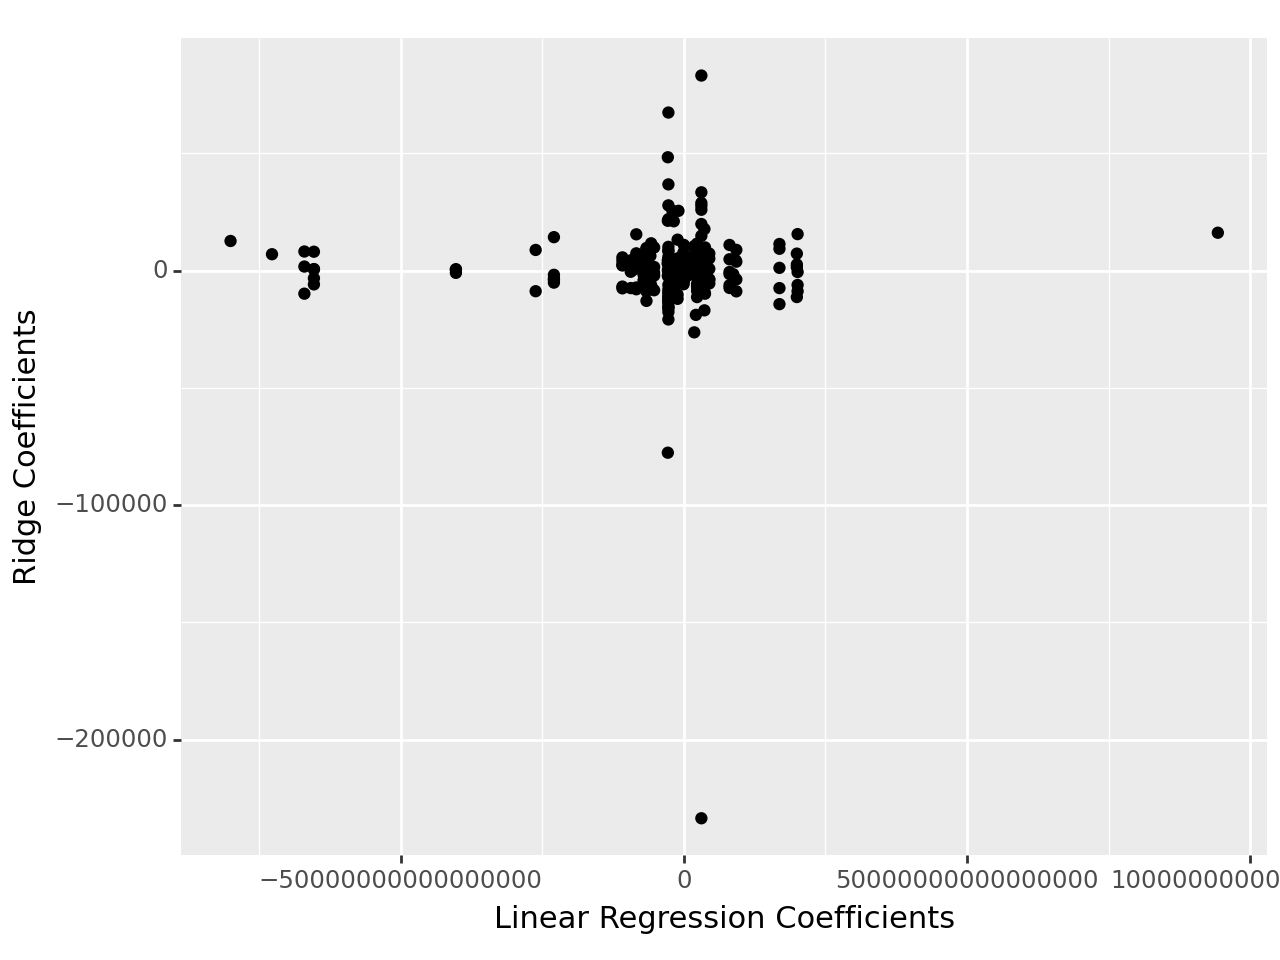

<Figure Size: (640 x 480)>

In [ ]:
from plotnine import *

plot = (ggplot(df, aes(x='Linear Regression Coefficients', y = 'Ridge Coefficients'))
+geom_point())

plot

## **PART 2**

Using the same pipeline as previously, perform tuning on lambda.

You should always try lambda values on a log scale; that is, don’t use [1,2,3,4]; instead use something like [0.001, 0.01, 0.1, 1, 10]

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:


ridge_pipeline_2 = Pipeline(
  [("preprocessing", ct),
  ("ridge_reg", Ridge())]
)

In [ ]:
degree_ridge = {'ridge_reg__alpha': np.array([.001,.01,.1,1,10])}

gscv = GridSearchCV(ridge_pipeline_2, degree_ridge, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X,y)

In [ ]:
pd.DataFrame({'Lambda':[.001,.01,.1,1,10], 'Scores':gscv_fitted.cv_results_['mean_test_score']})

,Lambda,Scores
0,0.001,0.852945
1,0.010,0.853224
2,0.100,0.855423
3,1.000,0.861159
4,10.000,0.863355


## **PART 3**

Create a LASSO pipeline, and tune lambda.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS

In [ ]:
lasso_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("lasso_reg", Lasso())]
)


In [ ]:
degree_lasso = {'lasso_reg__alpha': np.array([.001,.01,.1,1,10])}

gscv_lasso = GridSearchCV(lasso_pipeline_1, degree_lasso, cv = 5, scoring='r2')

gscv_fitted_lasso = gscv_lasso.fit(X,y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.103e+11, tolerance: 1.348e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.098e+11, tolerance: 1.474e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e+11, tolerance: 1.463e+09
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.p

In [ ]:
pd.DataFrame({'Lambda':[.001,.01,.1,1,10], 'Scores Lasso':gscv_fitted_lasso.cv_results_['mean_test_score'], 'Scores Ridge': gscv_fitted.cv_results_['mean_test_score']})

,Lambda,Scores Lasso,Scores Ridge
0,0.001,0.854440,0.852945
1,0.010,0.854549,0.853224
2,0.100,0.855394,0.855423
3,1.000,0.855890,0.861159
4,10.000,0.859495,0.863355


In [ ]:
ridge_pipeline_final = Pipeline(
  [("preprocessing", ct),
  ("ridge_reg", Ridge(10))]
)


lasso_pipeline_final = Pipeline(
  [("preprocessing", ct),
  ("lasso_reg", Lasso(10))]
)


ridge_pipeline_final_fitted = ridge_pipeline_final.fit(X,y)

ridge_coeffs = ridge_pipeline_final_fitted.named_steps['ridge_reg'].coef_


lasso_pipeline_final_fitted = lasso_pipeline_final.fit(X,y)

lasso_coeffs = lasso_pipeline_final_fitted.named_steps['lasso_reg'].coef_

In [ ]:
df = pd.DataFrame({
    'Ridge Coefficients': ridge_coeffs,
    'Lasso Coefficients': lasso_coeffs
})

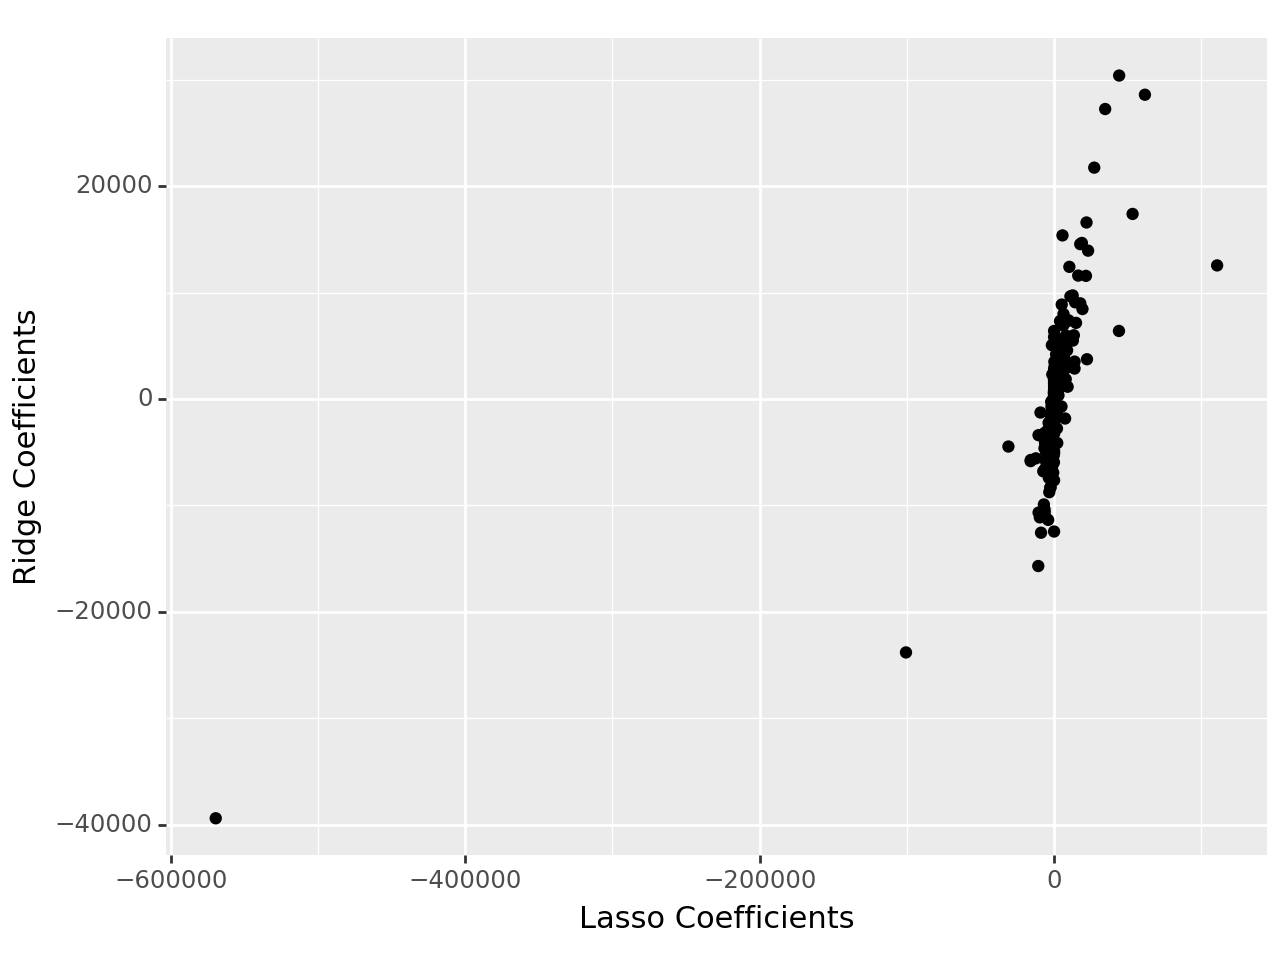

<Figure Size: (640 x 480)>

In [ ]:
plot = (ggplot(df, aes(x='Lasso Coefficients', y = 'Ridge Coefficients'))
+geom_point())

plot

## **PART 4**

Create an Elastic Net pipeline, and tune lambda and alpha.

Fit your best model on the full Ames data, and compare the coefficients to Ridge and OLS.

In [ ]:
elastic_net_pipe = Pipeline(
  [("preprocessing", ct),
  ("elastic_net_reg", ElasticNet())]
)


degree_EN = {'elastic_net_reg__alpha': np.array([.001,.01,.1,1,10, 20]),
             'elastic_net_reg__l1_ratio': np.arange(0, 1, .25)
}


gscv = GridSearchCV(elastic_net_pipe, degree_EN, cv = 5, scoring='r2')

gscv_fitted = gscv.fit(X,y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.497e+11, tolerance: 1.348e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.278e+11, tolerance: 1.474e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
/usr/local/lib/pyt

In [ ]:
results_df = pd.DataFrame(gscv_fitted.cv_results_)

resultsdf = results_df[['param_elastic_net_reg__alpha','param_elastic_net_reg__l1_ratio','mean_test_score', 'rank_test_score']]

resultsdf = resultsdf.rename(columns={
    'param_elastic_net_reg__alpha': 'Lambda',
    'param_elastic_net_reg__l1_ratio': 'Alpha',
    'mean_test_score': 'Score'
})
resultsdf.sort_values('rank_test_score')

,Lambda,Alpha,Score,rank_test_score
6,0.01,0.5,0.863342,1
7,0.01,0.75,0.863180,2
5,0.01,0.25,0.863116,3
4,0.01,0.0,0.862744,4
0,0.001,0.0,0.862390,5
1,0.001,0.25,0.862025,6
2,0.001,0.5,0.861381,7
11,0.1,0.75,0.860058,8
3,0.001,0.75,0.859864,9
10,0.1,0.5,0.856389,10


In [ ]:
elastic_final_pipe = Pipeline(
  [("preprocessing", ct),
  ("elastic_net_reg", ElasticNet(alpha=.5, l1_ratio=.01))]
)

elastic_final_pipe_fitted = elastic_final_pipe.fit(X,y)

elastic_coeffs = elastic_final_pipe_fitted.named_steps['elastic_net_reg'].coef_

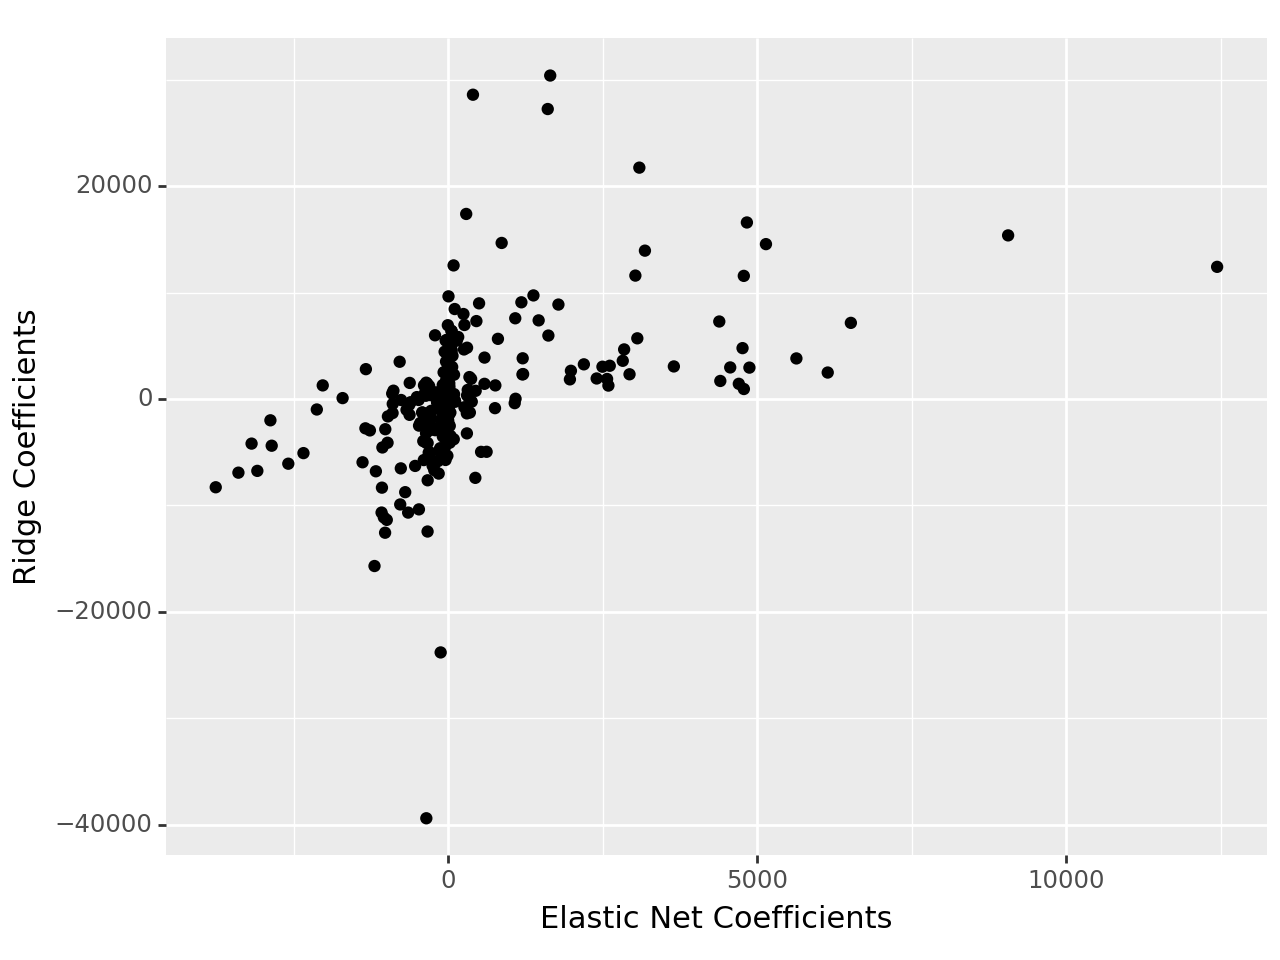

<Figure Size: (640 x 480)>

In [ ]:
df = pd.DataFrame({
    'Ridge Coefficients': ridge_coeffs,
    'Elastic Net Coefficients': elastic_coeffs
})

plot = (ggplot(df, aes(x='Elastic Net Coefficients', y = 'Ridge Coefficients'))
+geom_point())

plot

we can see the coefficients for the elastic net is a little closer to 0, which makes sense given the alpha of .5. The coefficients are not as close to 0 as the lasso, but closer than the ridge.